<a href="https://colab.research.google.com/github/haideraheem/Machine-Learning-/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt 
import sys 

In [ ]:
#Question 1

file_name = "data1.h5"
h5 = h5py.File(file_name, 'r')


In [ ]:
# This section imports the data and normalizes it and change the pictures to grayscale
h5_keys = list(h5.keys())
images = np.array(h5[h5_keys[0]])
R = np.array(h5[h5_keys[0]])[:,0,:,:]
G = h5[h5_keys[0]][:,1,:,:]
B = h5[h5_keys[0]][:,2,:,:]

Y = 0.2126*R + 0.7152*G + 0.0722*B 
x = []

for i in Y: 
  m = np.mean(i)
  std = np.std(i)
  i = i-m
  i = np.clip(i,-3*std, 3*std)
  x.append(np.interp(i, [-3*std, 3*std], [0.1, 0.9]).T)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

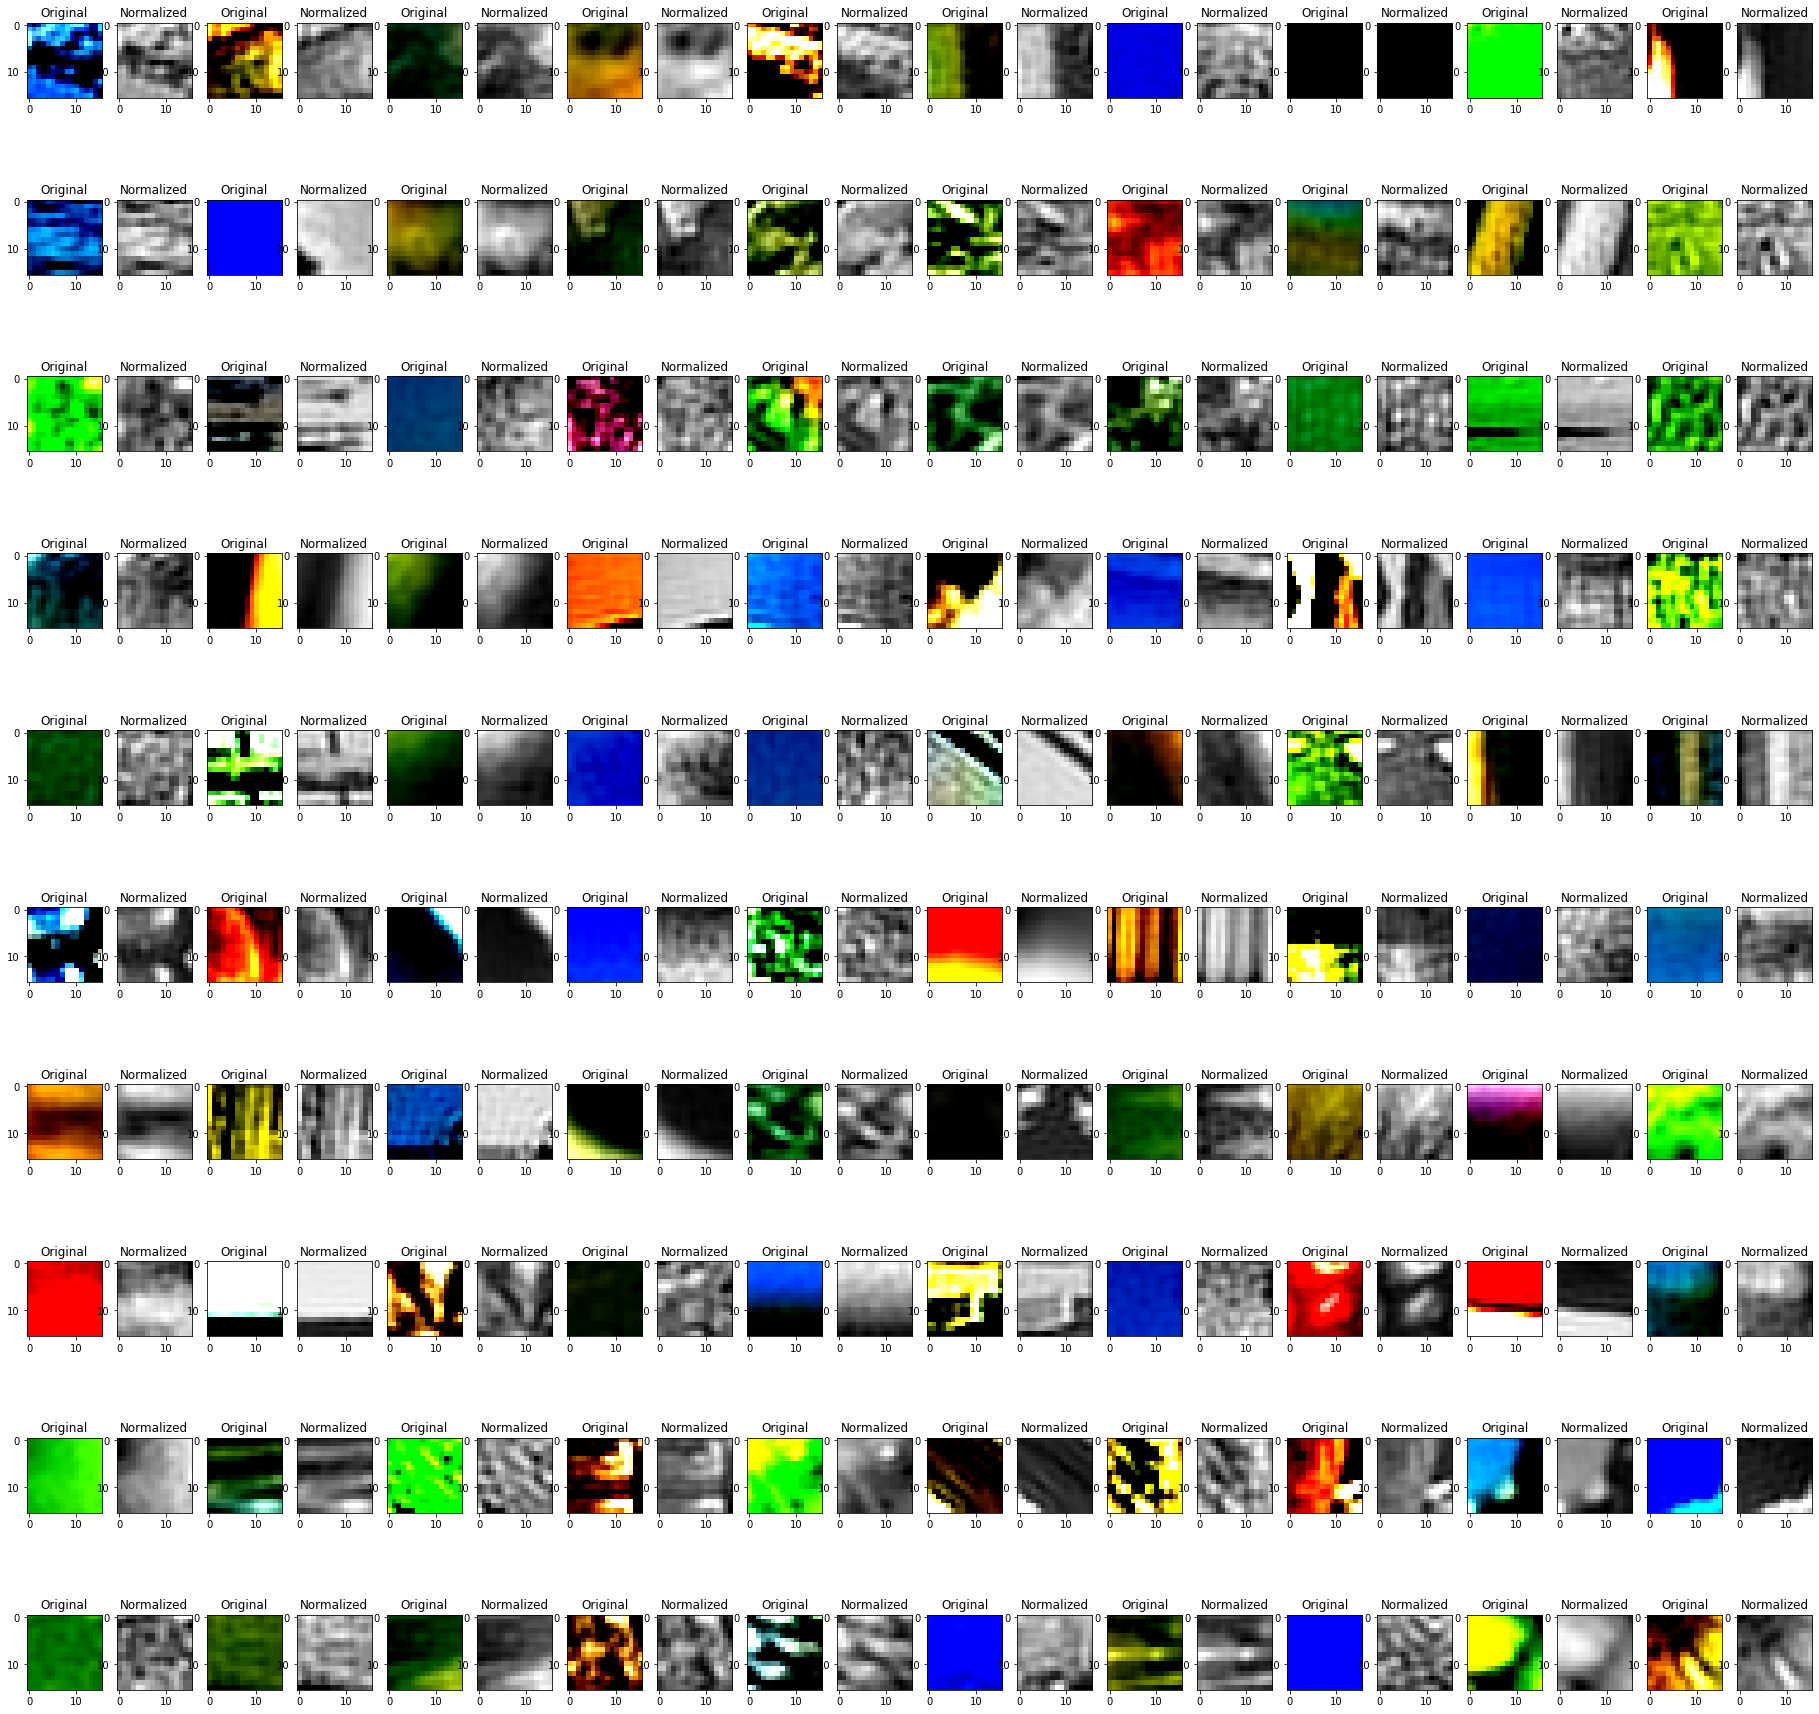

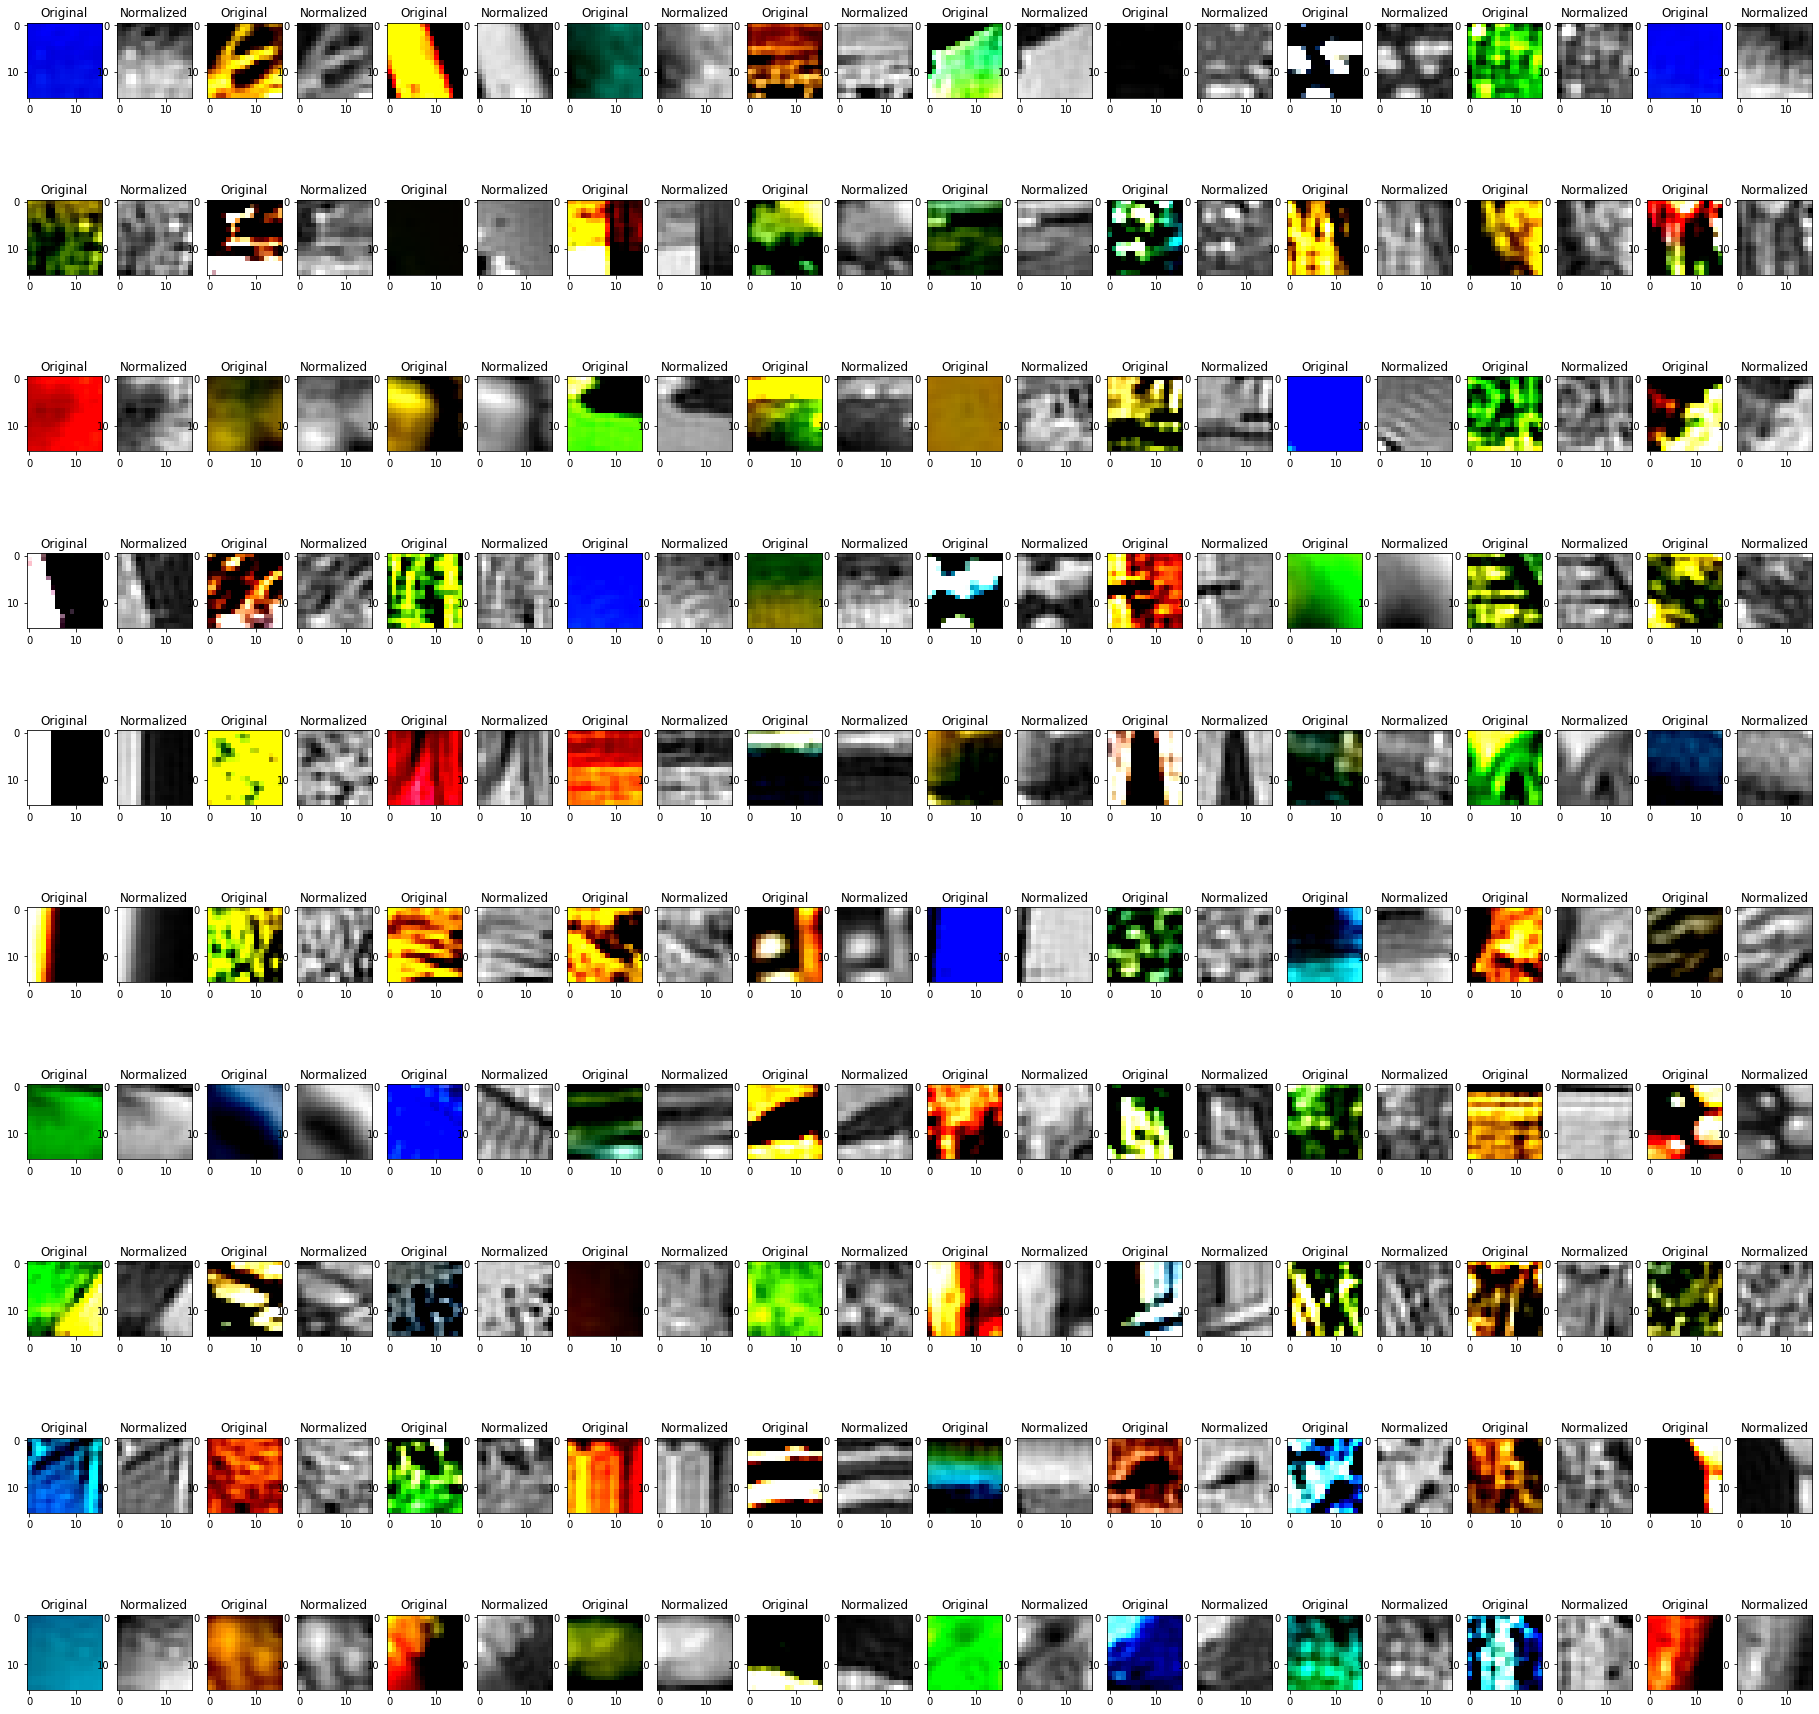

In [ ]:
#This part of the code plots 200 RGB and 200 Normalized pictures
fig1, axarr1 = plt.subplots(10,20, figsize= (32,32))
fig2, axarr2 = plt.subplots(10,20, figsize= (32,32))
axarr1= axarr1.ravel()
axarr2= axarr2.ravel()
N= 0
N1= 0 
for i in range(400):
  index = np.random.randint(0, len(images))
  if i >200 and N1< 200:
    axarr2[N1].imshow(images[index].T)
    axarr2[N1].set_title("Original")
    axarr2[N1+1].imshow(x[index], 'gray')
    axarr2[N1+1].set_title("Normalized")
    N1 = N1+2 
  elif i< 200 and N< 200: 
    axarr1[N].imshow(images[index].T)
    axarr1[N].set_title("Original")
    axarr1[N+1].imshow(x[index], 'gray')
    axarr1[N+1].set_title("Normalized")
    N = N+2
plt.show()

In [ ]:
x_reshaped = np.reshape(x, (len(x),256))


In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def dsigmoid(x):
  ds = sigmoid(x)*(1-sigmoid(x))
  return ds

In [ ]:
## Forward pass

def forward(x, wi):
  w1 = wi[0]
  w2 = wi[1]
  b1 = wi[2]
  b2 = wi[3]
  Y_inter = np.matmul(x,w1) + b1
  y1 = sigmoid(Y_inter)
  dy1 = dsigmoid(Y_inter)
  Y_inter1 = np.matmul(y1,w2) + b2
  y2 = sigmoid(Y_inter1)
  dy2 = dsigmoid(Y_inter1)
  wi = w1, w2, b1, b2 
  return y1, y2, dy1, dy2, wi

In [ ]:

y1, y2, dy1, dy2, wi = forward(x_reshaped, wi ) # Pass 1 


In [ ]:
def KLD(p, q):
  return np.sum(p * np.log(p/q) + (1 - p)*np.log((1-p) / (1 - q)))
def dKLD(p, q,N):
  return (-1*p/q + (1 - p)/(1 - q))/N

def cost_func(we, data, params):
  L_in, L_hid, lmbda, beta, rho = params
  x = data
  N = len(x[0])
  y1, y2, dy1, dy2, wi = forward(x, we)
  w1, w2, b1, b2 = wi 

  mse = (1/(2*N)) * np.sum(np.square((np.linalg.norm(x - y2, axis=1))))
  Tr = (lmbda/2) * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
  rho_b_hat = y1.mean(axis = 0, keepdims = True)
  kl = beta*KLD(rho, rho_b_hat)
  
  J = mse + Tr + kl

  ## Derivatives 
  dmse = ((x - y2)/N) *-1
  dtr1 = lmbda*w1
  dtr2 = lmbda*w2
  dkL = beta*dKLD(rho,rho_b_hat, N )

  cache = (y1, y2, dy1, dy2, wi)
  Jgrad = dmse, dtr1, dtr2, dkL 
  
  return cache, J, Jgrad 

def gradient_descent(x, m_wi, alpha, cache, lr, Jgrad):
  y1, y2, dy1, dy2, wi = cache
  dmse, dtr1, dtr2, dkl = Jgrad
  w1, w2, b1, b2 = wi
  m_w1, m_w2, m_b1, m_b2 = m_wi

  dw2 = dtr2 + np.matmul(y1.T, (dy2*dmse))
  db2 = np.sum((dmse*dy2), axis = 0, keepdims = True) 
  dw2 = ((np.matmul(x.T, (dy1 * (np.matmul((dmse*dy2), w2.T) + dkl))) + dtr1).T + dw2)/2
  dw1 = dw2.T
  db1 = np.sum((dy1 * (np.matmul((dmse*dy2), w2.T) + dkl)), axis = 0, keepdims=True)

  m_w1 = lr*dw1 + alpha*m_w1
  m_w2 = lr*dw2 + alpha*m_w2
  m_b1 = lr*db1 + alpha*m_b1
  m_b2 = lr*db2 + alpha*m_b2

  m_wi = m_w1, m_w2, m_b1, m_b2

## updating weights
  w1 = w1 - m_w1
  w2 = w2 - m_w2
  b1 = b1 -m_b1
  b2 = b2 - m_b2

  we = w1, w2, b1, b2
  return we , m_wi

In [ ]:
def train( we, x, params, lr, batch_size, epochs, alpha): 
  loss = []
  L_in, L_hid, lmbda, beta, rho = params


  for i in range(epochs):
    loss1 = 0
    batch_index = 0 
    m_wi = (0, 0, 0, 0)
    for j in range(int(len(x)/batch_size)):
      batch = x[batch_index: batch_index+batch_size]
      cache, J, Jgrad = cost_func(we, batch, params)
      we, m_wi = gradient_descent(batch, m_wi, alpha, cache, lr, Jgrad)
      batch_index = batch_index + batch_size
      loss1 = loss1 + J 
    loss.append(loss1)
    print(" Loss =", loss1, " for epoch ",i+1)
  
  return we, loss 


In [ ]:
lr = 0.0099
epochs = 200
rho = 0.001
beta = 0.00001
lmbda = 5e-4
batch_size = 512 
L_in = 256
L_out = 256
L_hid = 64
alpha = 0.95
m_wi = (0, 0, 0, 0)

L = L_in, L_out, L_hid
w0 = (6/(L_in +L_hid))**(1/2)
wi = [np.random.uniform(-w0,w0,(L_in, L_hid)), np.random.uniform(-w0,w0,(L_hid, L_out)), np.random.uniform(-w0,w0, L_hid), np.random.uniform(-w0,w0, L_out) ]

params = L_in, L_hid, lmbda, beta, rho 

we, loss = train( wi, x_reshaped, params, lr, batch_size, epochs, alpha )




 Loss = 104.58925153182555  for epoch  1
 Loss = 91.31022906276466  for epoch  2
 Loss = 89.51140392858947  for epoch  3
 Loss = 89.09973625583228  for epoch  4
 Loss = 88.62606032047758  for epoch  5
 Loss = 88.04556570586135  for epoch  6
 Loss = 87.32560801780195  for epoch  7
 Loss = 86.4422419812373  for epoch  8
 Loss = 85.37134029641332  for epoch  9
 Loss = 84.09795008108844  for epoch  10
 Loss = 82.61967947397947  for epoch  11
 Loss = 80.95360121573492  for epoch  12
 Loss = 79.13794316321815  for epoch  13
 Loss = 77.22990207047948  for epoch  14
 Loss = 75.29723640589725  for epoch  15
 Loss = 73.40685507955557  for epoch  16
 Loss = 71.61375592165588  for epoch  17
 Loss = 69.954641566628  for epoch  18
 Loss = 68.44747005040469  for epoch  19
 Loss = 67.0955682656771  for epoch  20
 Loss = 65.89327698674211  for epoch  21
 Loss = 64.83070450799289  for epoch  22
 Loss = 63.8965582507718  for epoch  23
 Loss = 63.07927683720652  for epoch  24
 Loss = 62.36720076764412  fo

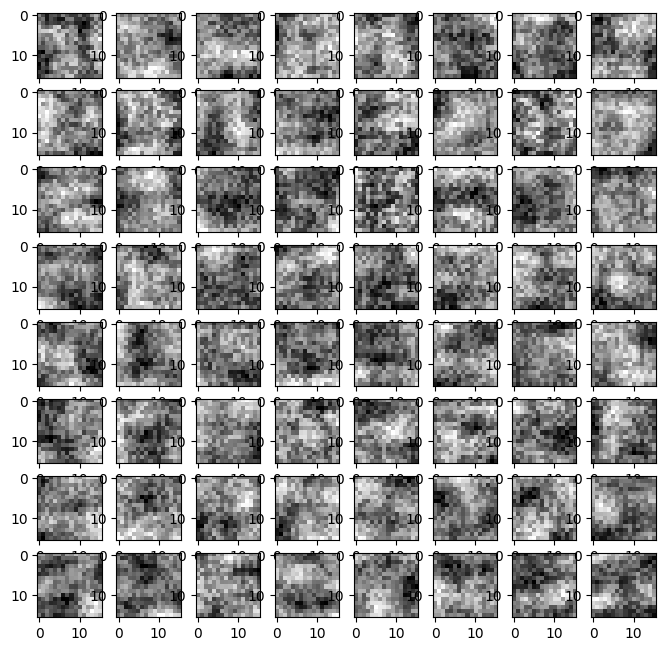

In [ ]:
features = np.reshape(we[0].T, (64, 16, 16))

fig3, axarr3 = plt.subplots(8,8,  figsize= (8,8), dpi=100, facecolor='w', edgecolor='k' )

axarr3= axarr3.ravel()
N= 0

for i in range(len(features)):
  axarr3[i].imshow(features[i], 'gray')

plt.show()

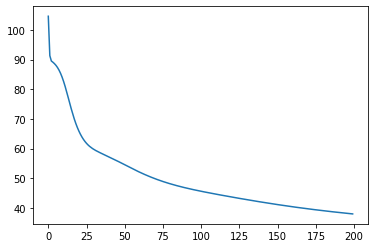

In [ ]:
plt.plot(loss)

In [ ]:
lr = 0.099
epochs = 200
rho = 0.001
beta = 0.001
lmbda = 1e-3
batch_size = 1024 
L_in = 256
L_out = 256
L_hid = 100
alpha = 0.95
m_wi = (0, 0, 0, 0)

L = L_in, L_out, L_hid
w0 = (6/(L_in +L_hid))**(1/2)
wi = [np.random.uniform(-w0,w0,(L_in, L_hid)), np.random.uniform(-w0,w0,(L_hid, L_out)), np.random.uniform(-w0,w0, L_hid), np.random.uniform(-w0,w0, L_out) ]

params = L_in, L_hid, lmbda, beta, rho 

we, loss = train( wi, x_reshaped, params, lr, batch_size, epochs, alpha )

 Loss = 106.51263466752143  for epoch  1
 Loss = 90.0197756477515  for epoch  2
 Loss = 81.49474053636816  for epoch  3
 Loss = 70.51236177534332  for epoch  4
 Loss = 63.12053954771368  for epoch  5
 Loss = 60.107547820365035  for epoch  6
 Loss = 58.537678360376056  for epoch  7
 Loss = 57.08570573335804  for epoch  8
 Loss = 55.51732256143352  for epoch  9
 Loss = 53.90616534485582  for epoch  10
 Loss = 52.352617985922706  for epoch  11
 Loss = 50.906661924696294  for epoch  12
 Loss = 49.60655041220519  for epoch  13
 Loss = 48.46617880228391  for epoch  14
 Loss = 47.46207927508959  for epoch  15
 Loss = 46.576140453950856  for epoch  16
 Loss = 45.78881987867155  for epoch  17
 Loss = 45.07242616805485  for epoch  18
 Loss = 44.402096355797674  for epoch  19
 Loss = 43.76139473224058  for epoch  20
 Loss = 43.143475594881984  for epoch  21
 Loss = 42.54674721138317  for epoch  22
 Loss = 41.97218151577749  for epoch  23
 Loss = 41.42119287131141  for epoch  24
 Loss = 40.8949285

In [ ]:
np.shape(we[0].T)

(100, 256)

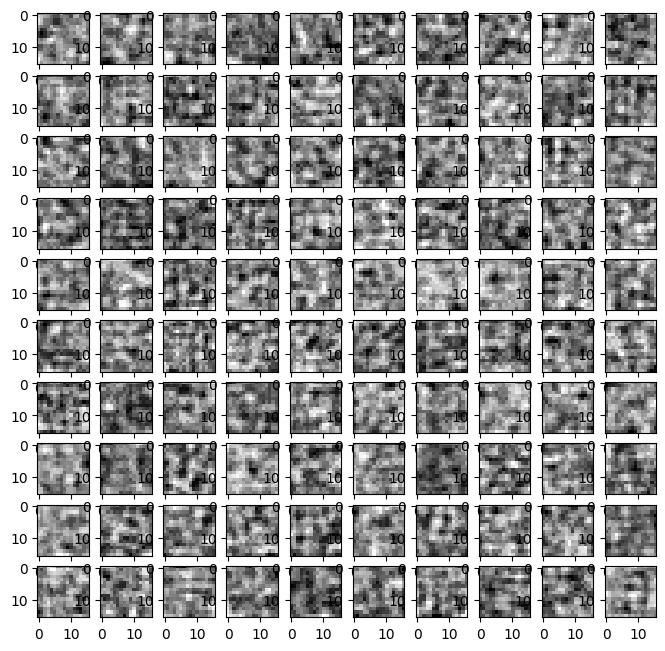

In [ ]:
features = np.reshape(we[0].T, (100, 16, 16))

fig3, axarr3 = plt.subplots(10,10,  figsize= (8,8), dpi=100, facecolor='w', edgecolor='k' )

axarr3= axarr3.ravel()
N= 0

for i in range(len(features)):
  axarr3[i].imshow(features[i], 'gray')

plt.show()

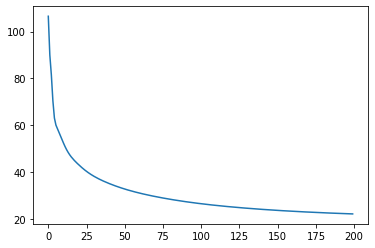

In [ ]:
plt.plot(loss)

In [ ]:
lr = 0.01
epochs = 200
rho = 0.001
beta = 0.00001
lmbda = 1e-1
batch_size = 2048
L_in = 256
L_out = 256
L_hid = 10
alpha = 0.95
m_wi = (0, 0, 0, 0)

L = L_in, L_out, L_hid
w0 = (6/(L_in +L_hid))**(1/2)
wi = [np.random.uniform(-w0,w0,(L_in, L_hid)), np.random.uniform(-w0,w0,(L_hid, L_out)), np.random.uniform(-w0,w0, L_hid), np.random.uniform(-w0,w0, L_out) ]

params = L_in, L_hid, lmbda, beta, rho 

we1, loss = train( wi, x_reshaped, params, lr, batch_size, epochs, alpha )

 Loss = 105.56101908502805  for epoch  1
 Loss = 102.21924308012247  for epoch  2
 Loss = 100.76682236445599  for epoch  3
 Loss = 99.92369542720864  for epoch  4
 Loss = 99.35317898259456  for epoch  5
 Loss = 98.92713734893184  for epoch  6
 Loss = 98.58784206120671  for epoch  7
 Loss = 98.30591864153912  for epoch  8
 Loss = 98.06471947430427  for epoch  9
 Loss = 97.85389864674092  for epoch  10
 Loss = 97.66652306775225  for epoch  11
 Loss = 97.49766043676254  for epoch  12
 Loss = 97.34363529243221  for epoch  13
 Loss = 97.2016099561103  for epoch  14
 Loss = 97.06933378608723  for epoch  15
 Loss = 96.94498456993603  for epoch  16
 Loss = 96.82706291486781  for epoch  17
 Loss = 96.71431857521758  for epoch  18
 Loss = 96.6056969308348  for epoch  19
 Loss = 96.50029878761633  for epoch  20
 Loss = 96.39734941162415  for epoch  21
 Loss = 96.29617426492274  for epoch  22
 Loss = 96.19617981607195  for epoch  23
 Loss = 96.09683833462898  for epoch  24
 Loss = 95.9976759026589

In [ ]:
np.shape(we[0])

(256, 100)

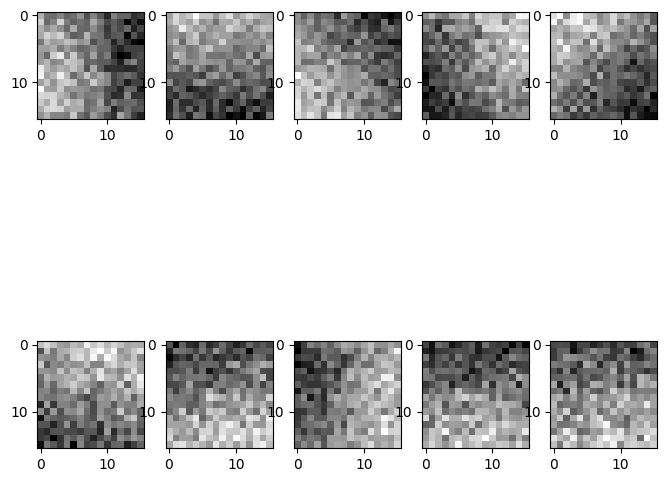

In [ ]:
features = np.reshape(we1[0].T, (10, 16, 16))

fig3, axarr3 = plt.subplots(2,5,  figsize= (8,8), dpi=100, facecolor='w', edgecolor='k' )

axarr3= axarr3.ravel()
N= 0

for i in range(len(features)):
  axarr3[i].imshow(features[i], 'gray')

plt.show()

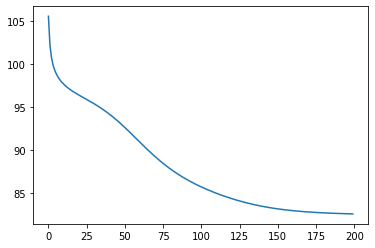

In [ ]:
plt.plot(loss)

In [ ]:
lr = 0.099
epochs = 200
rho = 0.001
beta = 0.00001
lmbda = 1e-2
batch_size = 2048
L_in = 256
L_out = 256
L_hid = 50
alpha = 0.95
m_wi = (0, 0, 0, 0)

L = L_in, L_out, L_hid
w0 = (6/(L_in +L_hid))**(1/2)
wi = [np.random.uniform(-w0,w0,(L_in, L_hid)), np.random.uniform(-w0,w0,(L_hid, L_out)), np.random.uniform(-w0,w0, L_hid), np.random.uniform(-w0,w0, L_out) ]

params = L_in, L_hid, lmbda, beta, rho 

we2, loss = train( wi, x_reshaped, params, lr, batch_size, epochs, alpha )

 Loss = 107.19906212094827  for epoch  1
 Loss = 98.7504024541636  for epoch  2
 Loss = 93.08692632014652  for epoch  3
 Loss = 91.31797138944671  for epoch  4
 Loss = 89.06427170874231  for epoch  5
 Loss = 85.342624603881  for epoch  6
 Loss = 80.59009701215213  for epoch  7
 Loss = 75.9897259404846  for epoch  8
 Loss = 72.33132182441517  for epoch  9
 Loss = 69.55543022883978  for epoch  10
 Loss = 67.47214111463101  for epoch  11
 Loss = 66.03847299468457  for epoch  12
 Loss = 65.09853098692295  for epoch  13
 Loss = 64.43890418597887  for epoch  14
 Loss = 63.890018871922166  for epoch  15
 Loss = 63.367022935472846  for epoch  16
 Loss = 62.83146192058322  for epoch  17
 Loss = 62.27606106019659  for epoch  18
 Loss = 61.70246615803747  for epoch  19
 Loss = 61.122018901167536  for epoch  20
 Loss = 60.54495928168608  for epoch  21
 Loss = 59.98344512580886  for epoch  22
 Loss = 59.443670316640436  for epoch  23
 Loss = 58.930260594177334  for epoch  24
 Loss = 58.441948933300

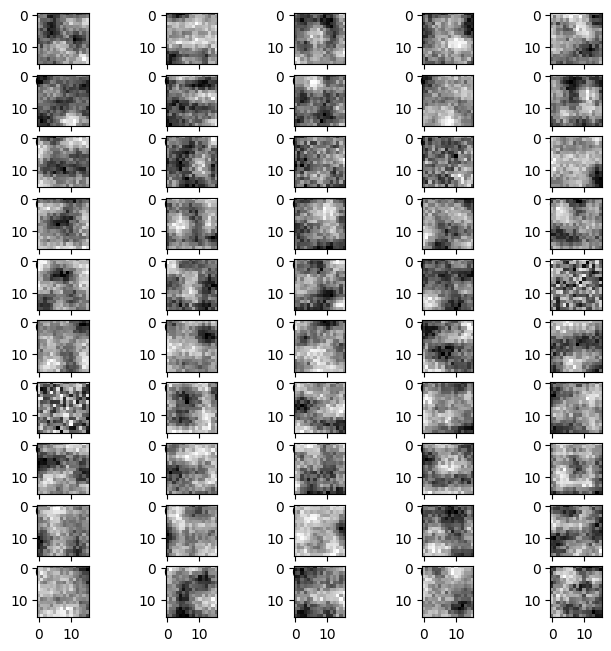

In [ ]:
features = np.reshape(we2[0].T, (50, 16, 16))

fig3, axarr3 = plt.subplots(10,5,  figsize= (8,8), dpi=100, facecolor='w', edgecolor='k' )

axarr3= axarr3.ravel()
N= 0

for i in range(len(features)):
  axarr3[i].imshow(features[i], 'gray')

plt.show()